## Imports

In [1]:
import cv2
import numpy as np
from numpy import save
import math as m
import matplotlib.pyplot as plt
import os
from scipy.io import savemat
import scipy.io
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from numpy import moveaxis
from numpy import asarray
import torch
from scipy.stats import multivariate_normal
import torchvision
from torch.linalg import multi_dot

## Hyperparameters

In [2]:
PathNPY1 = r"C:\Users\afadaei\Documents\GitHub\ViewGen\FaceData\Person_7\Image_134.npy"
PathNPY2 = r"C:\Users\afadaei\Documents\GitHub\ViewGen\FaceData\Person_7\Image_182.npy"

PathImg1 = r"C:\Users\afadaei\Documents\GitHub\ViewGen\FaceData\Person_7\Image_134.jpg"
PathImg2 = r"C:\Users\afadaei\Documents\GitHub\ViewGen\FaceData\Person_7\Image_182.jpg"

DEVICE=torch.device('cuda')
pi = 3.14159265359

## Functions

In [3]:
def showMask(data, height, width, img=None):
    if img != None:
      img[(height*data[:, 1]).long(), (width*data[:, 0]).long()] = 1
    else: 
      mask = torch.zeros((height, width), device=DEVICE)
      mask[(height*data[:, 1]).long(), (width*data[:, 0]).long()] = 1
    return mask


In [4]:
def showImageTensor(img, is3chan=True, isOutput=False, output=False):
  if isOutput:
    img = torch.squeeze(img)
    img /= 255
  img = img.cpu()
  if is3chan:
    plt.imshow(img.permute(1, 2, 0))
  else:
    plt.imshow(img)
  if output:
    return img

In [5]:
def createDiffMask(dataRef, dataTarg):
    # flowX = torch.zeros((height, width), dtype=torch.float64, device=DEVICE)
    # flowY = torch.zeros((height, width), dtype=torch.float64, device=DEVICE)
    dKey = dataRef - dataTarg
    # flowX[torch.floor((height*dataRef[:, 1])).long(), torch.floor((width*dataRef[:, 0])).long()] = dKey[:,0]
    # flowY[torch.floor((height*dataRef[:, 1])).long(), torch.floor((width*dataRef[:, 0])).long()] = dKey[:,1]
    # return flowX, flowY
    return dKey[:,0], dKey[:,1]

In [6]:
def measureWeight(x, y, data2, dKey, InterCov, distMethod):
    Sum = torch.zeros(1, device=DEVICE)
    Wsum = torch.zeros(1, device=DEVICE)
    
    if(distMethod == "gaussian"):
        d1 = torch.linspace(0, 1, height, device=DEVICE)
        d2 = torch.linspace(0, 1, width, device=DEVICE)

        meshx, meshy = torch.meshgrid(d1, d2, indexing='ij') 
        mx = meshx.clone()
        my = meshy.clone()
        MeshXE = mx.expand(478, 480, 640)
        MeshYE = my.expand(478, 480, 640)


        MeshXE = MeshXE - refKey[:, 1].view(-1, 1, 1)
        MeshYE = MeshYE - refKey[:, 0].view(-1, 1, 1)

        MeshE = torch.exp(-(MeshXE * MeshXE + MeshYE * MeshYE) / (2 * 0.01 * 0.01))
        
        WeightMeshX = MeshE * flowX.view(-1, 1, 1)
        WeightMeshY = MeshE * flowX.view(-1, 1, 1)

        InterpolatedFlowX = torch.sum(WeightMeshX, dim=0)/torch.sum(MeshE, dim=0)
        InterpolatedFlowY = torch.sum(WeightMeshY, dim=0)/torch.sum(MeshE, dim=0)
        return InterpolatedFlowX, InterpolatedFlowY
    if(distMethod == "l2"):
        for i in range(len(data2)):
            point = [data2[i, 1]-x, data2[i, 0]-y]
            w = 1/(point[0]*point[0] + point[1]*point[1]+0.0001)
            Wsum += w*dKey[i]
            Sum += w
        return Wsum/Sum
    elif(distMethod == "nn"):
        d = torch.zeros((len(data2)), dtype=torch.float64)
        numClosest = 4
        for i in range(len(data2)):
            d[i] = (data2[i, 1]-x)**2 + (data2[i, 0]-y)**2 
        idx = np.argpartition(d, numClosest)
        kk = idx[:numClosest]
        return sum(dKey[kk])/numClosest
    

In [7]:
def MyInterpol(height, width, dataRef, dataTarg, distMethod):
    dKey = dataRef - dataTarg
    flowX, flowY = dKey[:,0], dKey[:,1]
    d1 = torch.linspace(0, 1, height, device=DEVICE)
    d2 = torch.linspace(0, 1, width, device=DEVICE)

    meshx, meshy = torch.meshgrid(d1, d2, indexing='ij') 
    # mx = meshx.clone()
    # my = meshy.clone()
    MeshXE = meshx.expand(478, 480, 640)
    MeshYE = meshy.expand(478, 480, 640)


    MeshXE = MeshXE - refKey[:, 1].view(-1, 1, 1)
    MeshYE = MeshYE - refKey[:, 0].view(-1, 1, 1)

    MeshE = torch.exp(-100 * (MeshXE * MeshXE + MeshYE * MeshYE))
    WeightMeshX = MeshE * flowX.view(-1, 1, 1)
    WeightMeshY = MeshE * flowY.view(-1, 1, 1)

    InterpolatedFlowX = torch.sum(WeightMeshX, dim=0)/torch.sum(MeshE, dim=0)
    InterpolatedFlowY = torch.sum(WeightMeshY, dim=0)/torch.sum(MeshE, dim=0)
    return 2 * InterpolatedFlowX, 2 * InterpolatedFlowY


In [8]:
def RenderImage(height, width, refKey, tarKey, img):
    X, Y = MyInterpol(height, width, refKey, tarKey, "nn")
    d1 = torch.linspace(-1, 1, height)
    d2 = torch.linspace(-1, 1, width)
    meshx, meshy = torch.meshgrid(d1, d2, indexing='ij')
    meshx, meshy = meshx.cuda(), meshy.cuda()
    meshx = meshx + Y
    meshy = meshy + X
    grid = torch.stack((meshy, meshx), 2)
    grid = grid.unsqueeze(0)
    img = torch.tensor(img, dtype=torch.float, device=DEVICE)
    img = torch.unsqueeze(img, 0)
    grid = torch.tensor(grid, dtype=torch.float)
    output = torch.nn.functional.grid_sample(img, grid, padding_mode="border",align_corners=True)
    return output

In [9]:
def TransformKeys(keys, euler, T):
    R = torch.linalg.multi_dot((Rx(euler[0]), Ry(euler[1]), Rz(euler[2])))
    center = torch.mean(tarKey, dim=0)
    keys = keys - center
    out = torch.matmul(keys, R)
    return out + center + T
    

In [10]:
def Rx(theta):
    return torch.tensor([[ 1, 0           , 0           ],
                   [ 0, torch.cos(theta),-torch.sin(theta)],
                   [ 0, torch.sin(theta), torch.cos(theta)]], device=DEVICE, dtype=torch.double)
  
def Ry(theta):
    return torch.tensor([[ torch.cos(theta), 0, torch.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-torch.sin(theta), 0, torch.cos(theta)]], device=DEVICE, dtype=torch.double)
  
def Rz(theta):
    return torch.tensor([[ torch.cos(theta), -torch.sin(theta), 0 ],
                   [ torch.sin(theta), torch.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]], device=DEVICE, dtype=torch.double)

## Read data

In [11]:
imgRef = torchvision.io.read_image(PathImg1)
imgTar = torchvision.io.read_image(PathImg2)

refKey = torch.tensor(np.load(PathNPY1), device=DEVICE)
tarKey = torch.tensor(np.load(PathNPY2), device=DEVICE)


In [12]:
height, width = imgRef.shape[1], imgRef.shape[2]

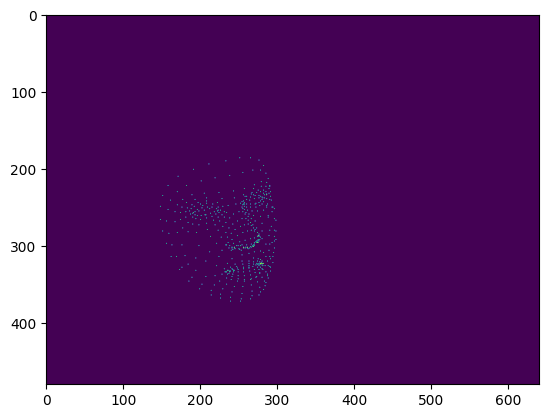

In [13]:
ll = showMask(refKey, height, width)
showImageTensor(ll, is3chan=False)

## PlayGround

In [14]:
output = RenderImage(height, width, refKey, tarKey, imgRef)

C:\Users\afadaei\AppData\Local\Temp\ipykernel_21700\2690309751.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float, device=DEVICE)
C:\Users\afadaei\AppData\Local\Temp\ipykernel_21700\2690309751.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid = torch.tensor(grid, dtype=torch.float)


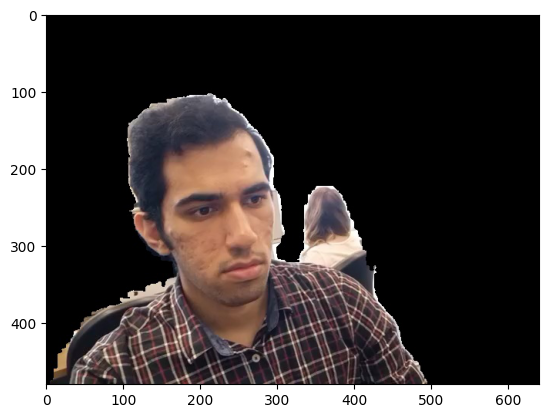

In [15]:
showImageTensor(imgRef)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


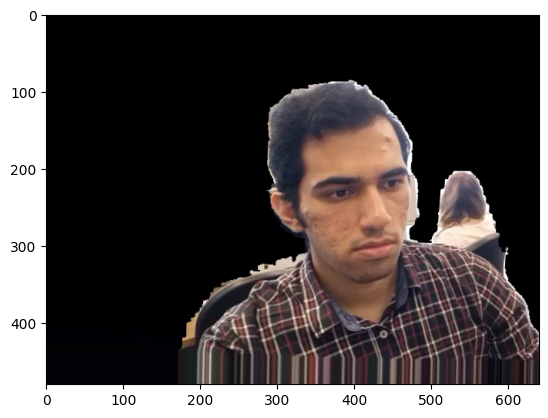

In [16]:
showImageTensor(output, isOutput=True)

In [42]:
euler = torch.tensor([pi/4, 0, 0], device=DEVICE)
T = torch.tensor([0, 0, 0], device=DEVICE)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [43]:
newKeys = TransformKeys(tarKey, euler, T)
output = RenderImage(height, width, refKey, newKeys, imgRef)
showImageTensor(output, isOutput=True)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [44]:
output
dummy = torch.squeeze(output)
dummy[:, (height*tarKey[:, 1]).long(), (width*tarKey[:, 0]).long()] = 1
img = showImageTensor(dummy, is3chan=True, output=True)
  # if isOutput:
  #   img = torch.squeeze(img)
  #   img /= 255
  # img = img.cpu()
  # if is3chan:
  #   plt.imshow(img.permute(1, 2, 0))
  # else:
  #   plt.imshow(img)
  # if output:
  #   return img

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

C:\Users\afadaei\AppData\Local\Temp\ipykernel_21700\2690309751.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float, device=DEVICE)
C:\Users\afadaei\AppData\Local\Temp\ipykernel_21700\2690309751.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grid = torch.tensor(grid, dtype=torch.float)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the vali

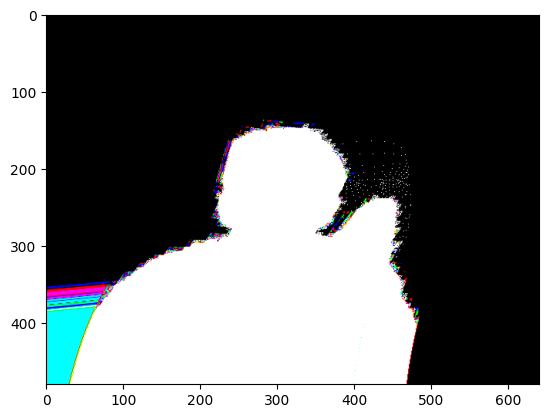

In [17]:
frameSize = (640, 480)

out = cv2.VideoWriter('idk.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 10, frameSize)

i = 0
j = 0
k = 0
T = -torch.mean(tarKey, axis=0) + torch.tensor([0.5, 0.5, 0], device=DEVICE)
for i in range(100):
  euler = torch.tensor([(i-50) * pi/200, (j-50) * pi/200, (k-50) * pi/200], device=DEVICE)
  # T = torch.tensor([0, 0, 0], device=DEVICE)
  newKeys = TransformKeys(tarKey, euler, T)
  output = RenderImage(height, width, refKey, newKeys, imgRef)
  dummy = torch.squeeze(output)
  dummy[:, (height*tarKey[:, 1]).long(), (width*tarKey[:, 0]).long()] = 1
  img = showImageTensor(dummy, is3chan=True, output=True)
  # img = showImageTensor(output, isOutput=True, output=True) * 255
  
  fuck = np.moveaxis(np.uint8(img), 0, -1)
  
  out.write(cv2.cvtColor(fuck, cv2.COLOR_BGR2RGB))

# for j in range(100):
#   euler = torch.tensor([(i-50) * pi/200, (j-50) * pi/200, (k-50) * pi/200], device=DEVICE)
#   # T = torch.tensor([0, 0, 0], device=DEVICE)
#   newKeys = TransformKeys(tarKey, euler, T)
#   output = RenderImage(height, width, refKey, newKeys, imgRef)
#   dummy = torch.squeeze(output)
#   dummy[:, (height*tarKey[:, 1]).long(), (width*tarKey[:, 0]).long()] = 1
#   img = showImageTensor(dummy, is3chan=True, output=True) * 255
#   # img = showImageTensor(output, isOutput=True, output=True) * 255
  
#   fuck = np.moveaxis(np.uint8(img), 0, -1)
  
#   out.write(cv2.cvtColor(fuck, cv2.COLOR_BGR2RGB))

# for k in range(100):
#   euler = torch.tensor([(i-50) * pi/200, (j-50) * pi/200, (k-50) * pi/200], device=DEVICE)
#   # T = torch.tensor([0, 0, 0], device=DEVICE)
#   newKeys = TransformKeys(tarKey, euler, T)
#   output = RenderImage(height, width, refKey, newKeys, imgRef)
#   dummy = torch.squeeze(output)
#   dummy[:, (height*tarKey[:, 1]).long(), (width*tarKey[:, 0]).long()] = 1
#   img = showImageTensor(dummy, is3chan=True, output=True) * 255
#   # img = showImageTensor(output, isOutput=True, output=True) * 255
  
#   fuck = np.moveaxis(np.uint8(img), 0, -1)
  
#   out.write(cv2.cvtColor(fuck, cv2.COLOR_BGR2RGB))

out.release()

In [ ]:
frameSize = (640, 480)

out = cv2.VideoWriter('keypoints.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 10, frameSize)

i = 0
j = 0
k = 0
T = -torch.mean(tarKey, axis=0) + torch.tensor([0.5, 0.5, 0], device=DEVICE)
for i in range(100):
  euler = torch.tensor([(i-50) * pi/200, (j-50) * pi/200, (k-50) * pi/200], device=DEVICE)
  newKeys = TransformKeys(tarKey, euler, T)

  output = showMask(newKeys, height, width) * 255


  img = showImageTensor(output, is3chan=False, isOutput=False, output=True)
  img = img.repeat(3,1,1)
  out.write(np.moveaxis(np.uint8(img), 0, -1))

for j in range(100):
  euler = torch.tensor([(i-50) * pi/200, (j-50) * pi/200, (k-50) * pi/200], device=DEVICE)
  newKeys = TransformKeys(tarKey, euler, T)

  output = showMask(newKeys, height, width) * 255


  img = showImageTensor(output, is3chan=False, isOutput=False, output=True)
  img = img.repeat(3,1,1)
  out.write(np.moveaxis(np.uint8(img), 0, -1))


for k in range(100):
  euler = torch.tensor([(i-50) * pi/200, (j-50) * pi/200, (k-50) * pi/200], device=DEVICE)
  newKeys = TransformKeys(tarKey, euler, T)

  output = showMask(newKeys, height, width) * 255


  img = showImageTensor(output, is3chan=False, isOutput=False, output=True)
  img = img.repeat(3,1,1)
  out.write(np.moveaxis(np.uint8(img), 0, -1))

out.release()